In [1]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pdb


# Size of feature map in discriminator
NDF = 16
# Size of feature map in Generator
NGF = 16
# Size of latent vector z (size of generator input)
NZ = 100
# Size of mini-batch
BS = 64
# Learning rate for Adam optimizer
LR = 0.0002
# Momentum value for Adam optimizer
BETA1 = 0.5
# Number of epoch
NUMEPOCHS = 20
# Number of channels of image
NC = 3
# Folder path to save model
PATH = './models/DC2_CIFAR_'

os.mkdir('./models')

class Generator(nn.Module):
    """Build a Generative Network."""
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(NZ, NGF*8*4*4),
            nn.BatchNorm1d(NGF*8*4*4),
            nn.ReLU(inplace=True))
        
        self.main = nn.Sequential(          
            nn.ConvTranspose2d(NGF*8, NGF*4, 4, 2, 1),
            nn.BatchNorm2d(NGF*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(NGF*4, NGF*2, 4, 2, 1),
            nn.BatchNorm2d(NGF*2),
            nn.ReLU(inplace=True),
        
            nn.ConvTranspose2d(NGF*2, NC, 4, 2, 1),
            nn.Tanh())
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, NGF*8, 4, 4)
        x = self.main(x)
        return x


class Discriminator(nn.Module):
    """Build a Discriminative Network."""
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1),
            nn.LeakyReLU(0.2,inplace=True),
        
            nn.Conv2d(NDF, NDF*2, 4, 2, 1),
            nn.BatchNorm2d(NDF*2),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(NDF*2, NDF*4, 4, 2, 1),
            nn.BatchNorm2d(NDF*4),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.fc = nn.Sequential(
            nn.Linear(4*4*NDF*4, 1),
            nn.Sigmoid())

    def forward(self, img):
        x = self.main(img)
        x = x.view(-1, 4*4*NDF*4)
        x = self.fc(x)
        return x
    
        
def weights_init(m):
    layerName = m.__class__.__name__
    if layerName.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0.0)

    
def load_dataset(batchSize):
    """Load MNIST dataset."""
    transform = transforms.Compose(
        [transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    trainset = dset.CIFAR10(root='./data', train=True, 
                            download=True, transform=transform)
    testset = dset.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                              shuffle=True, num_workers=2)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                             shuffle=True, num_workers=2)
    return trainLoader, testLoader

Files already downloaded and verified
Files already downloaded and verified
[0/20][0/782]	Loss_D = 1.3571	Loss_G = 0.8579	D(x) = 0.4903	D(G(z)) = 0.4486 / 0.4244
[0/20][50/782]	Loss_D = 0.8523	Loss_G = 1.3260	D(x) = 0.7280	D(G(z)) = 0.3518 / 0.2695
[0/20][100/782]	Loss_D = 0.5682	Loss_G = 1.8434	D(x) = 0.9116	D(G(z)) = 0.1951 / 0.1591
[0/20][150/782]	Loss_D = 0.4454	Loss_G = 2.2902	D(x) = 0.9736	D(G(z)) = 0.2639 / 0.1042
[0/20][200/782]	Loss_D = 0.5692	Loss_G = 2.2620	D(x) = 0.9495	D(G(z)) = 0.2270 / 0.1021
[0/20][250/782]	Loss_D = 0.5232	Loss_G = 1.8448	D(x) = 0.9405	D(G(z)) = 0.1977 / 0.1802
[0/20][300/782]	Loss_D = 0.7284	Loss_G = 1.9390	D(x) = 0.8787	D(G(z)) = 0.3991 / 0.1708
[0/20][350/782]	Loss_D = 0.6554	Loss_G = 1.9686	D(x) = 0.8856	D(G(z)) = 0.2938 / 0.1544
[0/20][400/782]	Loss_D = 0.6575	Loss_G = 1.7659	D(x) = 0.8864	D(G(z)) = 0.3224 / 0.1906
[0/20][450/782]	Loss_D = 0.6541	Loss_G = 3.3560	D(x) = 0.9008	D(G(z)) = 0.3697 / 0.0406
[0/20][500/782]	Loss_D = 0.9821	Loss_G = 1.6345

[5/20][650/782]	Loss_D = 0.8108	Loss_G = 1.4847	D(x) = 0.9009	D(G(z)) = 0.4535 / 0.2527
[5/20][700/782]	Loss_D = 0.6700	Loss_G = 1.4681	D(x) = 0.8964	D(G(z)) = 0.3639 / 0.2692
[5/20][750/782]	Loss_D = 0.7847	Loss_G = 1.4108	D(x) = 0.8447	D(G(z)) = 0.3615 / 0.2818
[6/20][0/782]	Loss_D = 0.7846	Loss_G = 1.1927	D(x) = 0.7657	D(G(z)) = 0.2552 / 0.3375
[6/20][50/782]	Loss_D = 0.8258	Loss_G = 1.2265	D(x) = 0.7907	D(G(z)) = 0.3320 / 0.3089
[6/20][100/782]	Loss_D = 0.8240	Loss_G = 1.3558	D(x) = 0.7666	D(G(z)) = 0.3313 / 0.2999
[6/20][150/782]	Loss_D = 0.8311	Loss_G = 1.3665	D(x) = 0.8202	D(G(z)) = 0.3891 / 0.2820
[6/20][200/782]	Loss_D = 0.8572	Loss_G = 1.0288	D(x) = 0.7610	D(G(z)) = 0.2906 / 0.3855
[6/20][250/782]	Loss_D = 0.8368	Loss_G = 1.2573	D(x) = 0.8305	D(G(z)) = 0.4183 / 0.3172
[6/20][300/782]	Loss_D = 0.8291	Loss_G = 1.4831	D(x) = 0.8152	D(G(z)) = 0.3626 / 0.2648
[6/20][350/782]	Loss_D = 0.8115	Loss_G = 1.3322	D(x) = 0.8397	D(G(z)) = 0.4329 / 0.2950
[6/20][400/782]	Loss_D = 0.8381	Los

[11/20][550/782]	Loss_D = 0.8218	Loss_G = 1.0257	D(x) = 0.8451	D(G(z)) = 0.4302 / 0.3857
[11/20][600/782]	Loss_D = 1.1207	Loss_G = 0.8083	D(x) = 0.6108	D(G(z)) = 0.3517 / 0.4682
[11/20][650/782]	Loss_D = 1.1791	Loss_G = 0.5806	D(x) = 0.6148	D(G(z)) = 0.4197 / 0.5806
[11/20][700/782]	Loss_D = 0.9720	Loss_G = 0.9003	D(x) = 0.7666	D(G(z)) = 0.4643 / 0.4385
[11/20][750/782]	Loss_D = 0.9271	Loss_G = 0.9139	D(x) = 0.7255	D(G(z)) = 0.3887 / 0.4257
[12/20][0/782]	Loss_D = 1.0203	Loss_G = 1.2254	D(x) = 0.7765	D(G(z)) = 0.5006 / 0.3184
[12/20][50/782]	Loss_D = 1.1072	Loss_G = 0.9741	D(x) = 0.6838	D(G(z)) = 0.4538 / 0.4028
[12/20][100/782]	Loss_D = 0.9962	Loss_G = 1.1247	D(x) = 0.7064	D(G(z)) = 0.3934 / 0.3614
[12/20][150/782]	Loss_D = 1.0400	Loss_G = 0.9360	D(x) = 0.6311	D(G(z)) = 0.3114 / 0.4154
[12/20][200/782]	Loss_D = 1.0666	Loss_G = 1.1474	D(x) = 0.7385	D(G(z)) = 0.5024 / 0.3544
[12/20][250/782]	Loss_D = 0.9116	Loss_G = 0.9523	D(x) = 0.7212	D(G(z)) = 0.3694 / 0.4009
[12/20][300/782]	Loss_D 

[17/20][400/782]	Loss_D = 0.9153	Loss_G = 0.9960	D(x) = 0.6990	D(G(z)) = 0.3470 / 0.3890
[17/20][450/782]	Loss_D = 1.0785	Loss_G = 1.2010	D(x) = 0.6424	D(G(z)) = 0.3843 / 0.3327
[17/20][500/782]	Loss_D = 0.8710	Loss_G = 1.2031	D(x) = 0.7870	D(G(z)) = 0.4078 / 0.3273
[17/20][550/782]	Loss_D = 1.1285	Loss_G = 0.9433	D(x) = 0.6905	D(G(z)) = 0.4688 / 0.4135
[17/20][600/782]	Loss_D = 1.0963	Loss_G = 0.9783	D(x) = 0.6786	D(G(z)) = 0.4622 / 0.3924
[17/20][650/782]	Loss_D = 1.1440	Loss_G = 0.6464	D(x) = 0.5838	D(G(z)) = 0.3645 / 0.5378
[17/20][700/782]	Loss_D = 0.8762	Loss_G = 0.9598	D(x) = 0.8709	D(G(z)) = 0.4958 / 0.4095
[17/20][750/782]	Loss_D = 1.0458	Loss_G = 1.0698	D(x) = 0.7968	D(G(z)) = 0.5231 / 0.3579
[18/20][0/782]	Loss_D = 1.0909	Loss_G = 1.0403	D(x) = 0.8001	D(G(z)) = 0.5869 / 0.3728
[18/20][50/782]	Loss_D = 1.0834	Loss_G = 0.6427	D(x) = 0.6604	D(G(z)) = 0.4303 / 0.5512
[18/20][100/782]	Loss_D = 0.7563	Loss_G = 1.2515	D(x) = 0.8486	D(G(z)) = 0.3600 / 0.3110
[18/20][150/782]	Loss_D 

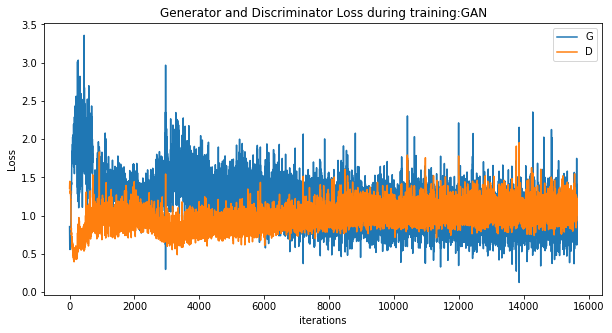

<Figure size 432x288 with 0 Axes>

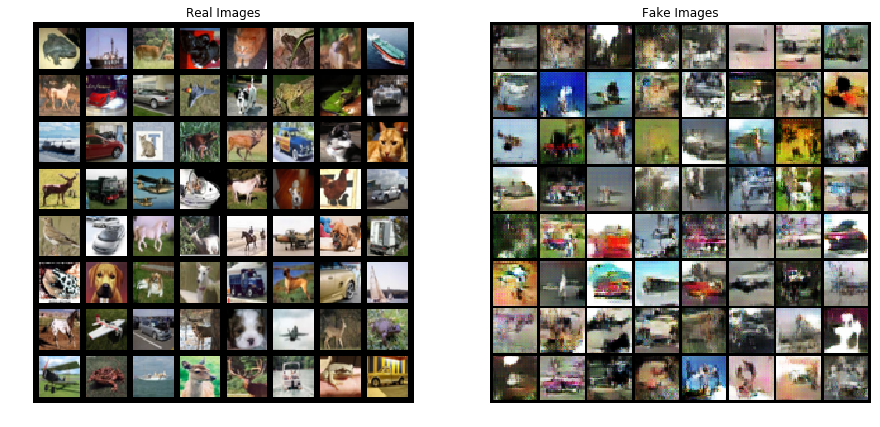

In [3]:
def train():
    """Build, train GAN."""    
    # Load dataset
    trainLoader, testLoader = load_dataset(BS)
    
    # Decide which device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    # # Create a batch of data
    # realBatch = next(iter(trainLoader))
    # assert len(realBatch[0]) == 128
    # assert len(realBatch[1]) == 128
    # assert realBatch[0].size() == torch.Size([128, 1, 32, 32])
    
    # Build and initialize the network
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
        
    # Initialize BCELoss function
    criterion = nn.BCELoss()
       
    # Create batch of latent vectors
    fixedNoise = torch.randn(64, NZ, device=device)
        
    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    # Training loop
    imgList = []
    DLosses = []
    GLosses = []
    iters = 0
        
    for epoch in range(NUMEPOCHS):
        for i, data in enumerate(trainLoader, 0):
            # (1) Update Discriminator, maximize log(D(x)) + log(1 - D(G(z)))
            # Train with all-real images batch
            netD.zero_grad()
            realImg = data[0].to(device)
            batchSize = realImg.size(0)
            # Use soft labels
            realLabel = torch.full((batchSize,), 1, device=device)
            realLabel = realLabel + torch.randn(batchSize, device=device)/15
            output = netD(realImg).view(-1)
            errDReal = criterion(output, realLabel)
            errDReal.backward()
            D_x = output.mean().item()
             
            # Train with all-fake noises batch
            noise = torch.randn(batchSize, NZ, device=device)
            fakeImg = netG(noise)
            output = netD(fakeImg.detach()).view(-1)
            # Use soft labels
            fakeLabel = torch.full((batchSize,), 0, device=device)
            fakeLabel = fakeLabel + torch.rand(batchSize, device=device)/3
            errDFake = criterion(output, fakeLabel)
            errDFake.backward()
            D_G_z1 = output.mean().item()
            errD = errDReal + errDFake
            # Update Discriminator
            optimizerD.step()
              
            # (2) Update Generator, maximize log(D(G(z)))
            netG.zero_grad()
            output = netD(fakeImg).view(-1)
            errG = criterion(output, realLabel)
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update Generator
            optimizerG.step()
              
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D = %.4f\tLoss_G = %.4f\tD(x) = %.4f\tD(G(z)) = %.4f / %.4f' 
                      % (epoch, NUMEPOCHS, i, len(trainLoader), errD.item(), 
                         errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save loss for plotting later
            GLosses.append(errG.item())
            DLosses.append(errD.item())
             
            # Check how netG is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == NUMEPOCHS - 1) and 
                                      (i == len(trainLoader) - 1)):
                with torch.no_grad():
                    fake = netG(fixedNoise).detach().cpu()
                    imgList.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1
                
    # Save the network
    torch.save(netG.state_dict(), PATH+'netG.pt')
    torch.save(netD.state_dict(), PATH+'netD.pt')
    
    # Plot of Discriminator and Generator's losses  
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator Loss during training:GAN')
    plt.plot(GLosses, label='G')
    plt.plot(DLosses, label='D')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(PATH+'loss_GAN.png')
        
    # Real image versus fake images
    realBatch = next(iter(trainLoader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Real Images')
    plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, 
                                    normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Fake Images')
    plt.imshow(np.transpose(imgList[-1], (1,2,0)))
    plt.show()
    
    
# Train DCGAN normally 
train()

Files already downloaded and verified
Files already downloaded and verified
[0/20][0/782]	Loss_D = 1.4005	Loss_G = 0.7328	D(x) = 0.5063	D(G(z)) = 0.5070 / 0.4806
[0/20][50/782]	Loss_D = 0.6810	Loss_G = 1.4953	D(x) = 0.8247	D(G(z)) = 0.2950 / 0.2255
[0/20][100/782]	Loss_D = 0.5340	Loss_G = 1.9094	D(x) = 0.9181	D(G(z)) = 0.1696 / 0.1498
[0/20][150/782]	Loss_D = 0.6698	Loss_G = 1.8925	D(x) = 0.9148	D(G(z)) = 0.3258 / 0.1513
[0/20][200/782]	Loss_D = 0.5524	Loss_G = 1.7683	D(x) = 0.9015	D(G(z)) = 0.2550 / 0.1822
[0/20][250/782]	Loss_D = 0.8259	Loss_G = 1.9284	D(x) = 0.8913	D(G(z)) = 0.4484 / 0.1728
[0/20][300/782]	Loss_D = 0.7839	Loss_G = 2.2122	D(x) = 0.8366	D(G(z)) = 0.3458 / 0.1158
[0/20][350/782]	Loss_D = 0.7013	Loss_G = 2.1184	D(x) = 0.8460	D(G(z)) = 0.3093 / 0.1236
[0/20][400/782]	Loss_D = 0.8832	Loss_G = 1.4783	D(x) = 0.7789	D(G(z)) = 0.3641 / 0.2426
[0/20][450/782]	Loss_D = 0.8792	Loss_G = 1.5502	D(x) = 0.7620	D(G(z)) = 0.3669 / 0.2227
[0/20][500/782]	Loss_D = 0.9349	Loss_G = 1.6847

[5/20][650/782]	Loss_D = 0.8664	Loss_G = 1.3809	D(x) = 0.8409	D(G(z)) = 0.4355 / 0.2591
[5/20][700/782]	Loss_D = 0.7354	Loss_G = 1.1360	D(x) = 0.8381	D(G(z)) = 0.3126 / 0.3339
[5/20][750/782]	Loss_D = 0.9417	Loss_G = 1.3131	D(x) = 0.8271	D(G(z)) = 0.4538 / 0.2717
[6/20][0/782]	Loss_D = 0.8523	Loss_G = 1.2986	D(x) = 0.8295	D(G(z)) = 0.3942 / 0.2866
[6/20][50/782]	Loss_D = 0.9588	Loss_G = 1.0916	D(x) = 0.7762	D(G(z)) = 0.4367 / 0.3456
[6/20][100/782]	Loss_D = 0.8088	Loss_G = 1.3246	D(x) = 0.8453	D(G(z)) = 0.4294 / 0.2790
[6/20][150/782]	Loss_D = 0.8893	Loss_G = 1.3299	D(x) = 0.8312	D(G(z)) = 0.4240 / 0.2709
[6/20][200/782]	Loss_D = 0.9183	Loss_G = 1.3557	D(x) = 0.7550	D(G(z)) = 0.3612 / 0.2668
[6/20][250/782]	Loss_D = 0.8820	Loss_G = 1.2547	D(x) = 0.8140	D(G(z)) = 0.4345 / 0.2926
[6/20][300/782]	Loss_D = 0.8495	Loss_G = 1.3185	D(x) = 0.8531	D(G(z)) = 0.4301 / 0.2758
[6/20][350/782]	Loss_D = 0.8966	Loss_G = 1.0496	D(x) = 0.7493	D(G(z)) = 0.3465 / 0.3653
[6/20][400/782]	Loss_D = 0.7853	Los

[11/20][550/782]	Loss_D = 0.8937	Loss_G = 1.2537	D(x) = 0.7442	D(G(z)) = 0.3076 / 0.2959
[11/20][600/782]	Loss_D = 0.7846	Loss_G = 1.3099	D(x) = 0.8269	D(G(z)) = 0.3226 / 0.2819
[11/20][650/782]	Loss_D = 0.9160	Loss_G = 1.1754	D(x) = 0.8394	D(G(z)) = 0.4678 / 0.3150
[11/20][700/782]	Loss_D = 0.8256	Loss_G = 1.3974	D(x) = 0.8308	D(G(z)) = 0.3739 / 0.2526
[11/20][750/782]	Loss_D = 0.8874	Loss_G = 1.1572	D(x) = 0.7785	D(G(z)) = 0.3823 / 0.3293
[12/20][0/782]	Loss_D = 0.9427	Loss_G = 0.8587	D(x) = 0.7796	D(G(z)) = 0.3620 / 0.4324
[12/20][50/782]	Loss_D = 0.9235	Loss_G = 1.1708	D(x) = 0.7684	D(G(z)) = 0.3809 / 0.3182
[12/20][100/782]	Loss_D = 0.8889	Loss_G = 1.1926	D(x) = 0.7768	D(G(z)) = 0.3836 / 0.3087
[12/20][150/782]	Loss_D = 0.9999	Loss_G = 0.8350	D(x) = 0.7845	D(G(z)) = 0.3999 / 0.4388
[12/20][200/782]	Loss_D = 0.9257	Loss_G = 1.2940	D(x) = 0.8534	D(G(z)) = 0.4679 / 0.2823
[12/20][250/782]	Loss_D = 0.8262	Loss_G = 1.1529	D(x) = 0.7805	D(G(z)) = 0.3066 / 0.3226
[12/20][300/782]	Loss_D 

[17/20][400/782]	Loss_D = 0.8312	Loss_G = 1.1705	D(x) = 0.8139	D(G(z)) = 0.3732 / 0.3172
[17/20][450/782]	Loss_D = 0.8451	Loss_G = 1.2220	D(x) = 0.8403	D(G(z)) = 0.3871 / 0.3018
[17/20][500/782]	Loss_D = 0.9376	Loss_G = 1.1071	D(x) = 0.7531	D(G(z)) = 0.4010 / 0.3371
[17/20][550/782]	Loss_D = 0.8005	Loss_G = 1.1313	D(x) = 0.7911	D(G(z)) = 0.3343 / 0.3307
[17/20][600/782]	Loss_D = 0.9030	Loss_G = 1.1930	D(x) = 0.7589	D(G(z)) = 0.3721 / 0.3072
[17/20][650/782]	Loss_D = 0.9530	Loss_G = 0.9901	D(x) = 0.7518	D(G(z)) = 0.3498 / 0.3756
[17/20][700/782]	Loss_D = 0.9173	Loss_G = 1.1636	D(x) = 0.7610	D(G(z)) = 0.3478 / 0.3228
[17/20][750/782]	Loss_D = 0.9340	Loss_G = 1.2360	D(x) = 0.8152	D(G(z)) = 0.4786 / 0.2968
[18/20][0/782]	Loss_D = 1.4332	Loss_G = 1.3537	D(x) = 0.8929	D(G(z)) = 0.6472 / 0.2642
[18/20][50/782]	Loss_D = 0.8442	Loss_G = 1.1327	D(x) = 0.7549	D(G(z)) = 0.3324 / 0.3282
[18/20][100/782]	Loss_D = 0.8958	Loss_G = 1.0912	D(x) = 0.8172	D(G(z)) = 0.4204 / 0.3415
[18/20][150/782]	Loss_D 

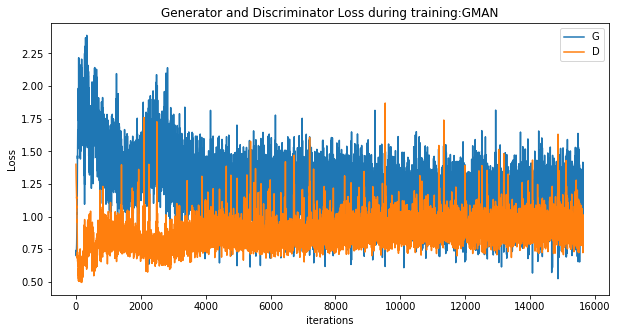

<Figure size 432x288 with 0 Axes>

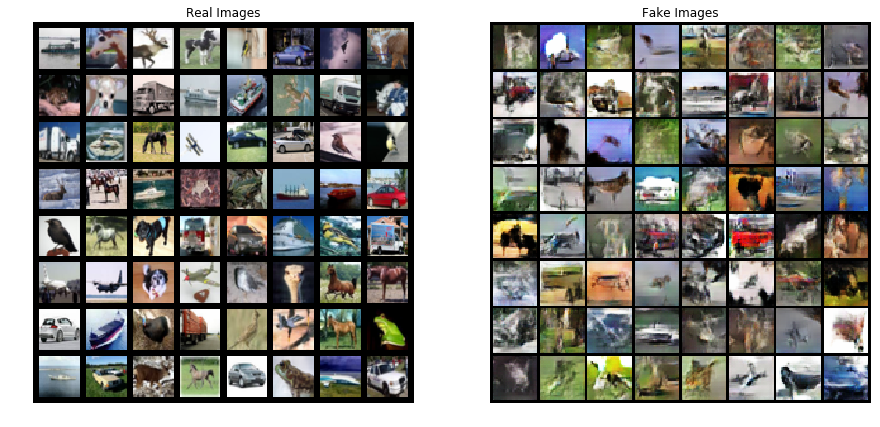

In [4]:
def train_with_GMAN():
    """Build, train GAN with GMAN."""    
    # Load dataset
    trainLoader, testLoader = load_dataset(BS)
    
    # Decide which device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    #     # Create a batch of data
    #     realBatch = next(iter(trainLoader))
    #     assert len(realBatch[0]) == 128
    #     assert len(realBatch[1]) == 128
    #     assert realBatch[0].size() == torch.Size([128, 1, 32, 32])
    
    # Build and initialize the network
    MnetG = Generator().to(device)
    netD1 = Discriminator().to(device)
    netD2 = Discriminator().to(device)
    netD3 = Discriminator().to(device)
    netD4 = Discriminator().to(device)
    netD5 = Discriminator().to(device)
    
    MnetG.apply(weights_init)
    netD1.apply(weights_init)
    netD2.apply(weights_init)
    netD3.apply(weights_init)
    netD4.apply(weights_init)
    netD5.apply(weights_init)
    
    # Initialize BCELoss function
    criterion = nn.BCELoss()
    
    # Create batch of latent vectors
    fixedNoise = torch.randn(64, NZ, device=device)
    
    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(MnetG.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD1 = optim.Adam(netD1.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD2 = optim.Adam(netD2.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD3 = optim.Adam(netD3.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD4 = optim.Adam(netD4.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD5 = optim.Adam(netD5.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    # Training loop
    imgList = []
    DLosses = []
    GLosses = []
    iters = 0
    
    for epoch in range(NUMEPOCHS):
        for i, data in enumerate(trainLoader, 0):
            # (1) Update Discriminator, maximize log(D(x)) + log(1 - D(G(z)))
            # Train with all-real images batch
            netD1.zero_grad()
            netD2.zero_grad()
            netD3.zero_grad()
            netD4.zero_grad()
            netD5.zero_grad()
    
            optimizerD1.zero_grad()
            optimizerD2.zero_grad()  
            optimizerD3.zero_grad()
            optimizerD4.zero_grad()
            optimizerD5.zero_grad()
    
            realImg = data[0].to(device)
            batchSize = realImg.size(0)
            # Use soft labels
            realLabel = torch.full((batchSize,), 1, device = device)
            realLabel = realLabel + torch.randn(batchSize, device=device)/15
    
            noise = torch.randn(batchSize, NZ, device=device)
            fakeImg = MnetG(noise)
            # Use soft labels
            fakeLabel = torch.full((batchSize,), 0, device=device)
            fakeLabel = fakeLabel + torch.rand(batchSize, device=device)/3
    
            # Update all discriminators with batch of real and then fake data
            output1 = netD1(realImg).view(-1)
            errD1Real = criterion(output1, realLabel)
    
            output2 = netD2(realImg).view(-1)
            errD2Real = criterion(output2, realLabel)
    
            output3 = netD3(realImg).view(-1)
            errD3Real = criterion(output3, realLabel)
    
            output4 = netD4(realImg).view(-1)
            errD4Real = criterion(output4, realLabel)
    
            output5 = netD5(realImg).view(-1)
            errD5Real = criterion(output5, realLabel)
    
            output = (output1 + output2 + output3 + output4 + output5)/5
            D_x = output.mean().item()
    
            output1 = netD1(fakeImg.detach()).view(-1)
            errD1Fake = criterion(output1, fakeLabel)
            errD1 = errD1Real + errD1Fake
            errD1.backward()
            optimizerD1.step()
    
            output2 = netD2(fakeImg.detach()).view(-1)
            errD2Fake = criterion(output2, fakeLabel)
            errD2 = errD2Real + errD2Fake
            errD2.backward()
            optimizerD2.step()
    
            output3 = netD3(fakeImg.detach()).view(-1)
            errD3Fake = criterion(output3, fakeLabel)
            errD3 = errD3Real + errD3Fake
            errD3.backward()
            optimizerD3.step()
    
            output4 = netD4(fakeImg.detach()).view(-1)
            errD4Fake = criterion(output4, fakeLabel)
            errD4 = errD4Real + errD4Fake
            errD4.backward()
            optimizerD4.step()
    
            output5 = netD5(fakeImg.detach()).view(-1)
            errD5Fake = criterion(output5, fakeLabel)
            errD5 = errD5Real + errD5Fake
            errD5.backward()
            optimizerD5.step()
    
            output = 0.2*(output1+output2+output3+output4+output5)
            D_G_z1 = output.mean().item()
    
            errD = (errD1 + errD2 + errD3 + errD4 + errD5) / 5
    
            # (2) Update Generator, maximize log(D(G(z)))
            MnetG.zero_grad()
            output1 = netD1(fakeImg).view(-1)
            output2 = netD2(fakeImg).view(-1)
            output3 = netD3(fakeImg).view(-1)
            output4 = netD4(fakeImg).view(-1)
            output5 = netD5(fakeImg).view(-1)
    
            errG1 = criterion(output1, realLabel)
            errG2 = criterion(output2, realLabel)
            errG3 = criterion(output3, realLabel)
            errG4 = criterion(output4, realLabel)
            errG5 = criterion(output5, realLabel)
            errG = (errG1 + errG2 + errG3 + errG4 + errG5)/5
            output = (output1 + output2 + output3 + output4 + output5)/5 
            errG = criterion(output, realLabel)
            errG.backward()
            optimizerG.step()
            D_G_z2 = output.mean().item()
            # Update Generator
            #optimizerG.step()
    
    
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D = %.4f\tLoss_G = %.4f\tD(x) = %.4f\tD(G(z)) = %.4f / %.4f' 
                      % (epoch, NUMEPOCHS, i, len(trainLoader), errD.item(), 
                         errG.item(), D_x, D_G_z1, D_G_z2))  
    
            # Save loss for plotting later
            GLosses.append(errG.item())
            DLosses.append(errD.item())
    
            # Check how MnetG is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == NUMEPOCHS - 1) and 
                                      (i == len(trainLoader) - 1)):
                with torch.no_grad():
                    fake = MnetG(fixedNoise).detach().cpu()
                    imgList.append(vutils.make_grid(fake, padding=2, 
                                                    normalize=True))
            iters += 1
    
    torch.save(MnetG.state_dict(), PATH+'MnetG.pt')
    torch.save(netD1.state_dict(), PATH+'netD1.pt')
    torch.save(netD2.state_dict(), PATH+'netD2.pt')
    torch.save(netD3.state_dict(), PATH+'netD3.pt')
    torch.save(netD4.state_dict(), PATH+'netD4.pt')
    torch.save(netD5.state_dict(), PATH+'netD5.pt')
    
    # Plot of Discriminator and Generator's losses  
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator Loss during training:GMAN')
    plt.plot(GLosses, label='G')
    plt.plot(DLosses, label='D')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 
    plt.savefig(PATH+'LOSS_GMAN.png')
    
    # Real image versus fake images
    realBatch = next(iter(trainLoader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Real Images')
    plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, 
                                    normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Fake Images')
    plt.imshow(np.transpose(imgList[-1], (1,2,0)))
    plt.show()


# Train DCGAN with GMAN
train_with_GMAN()

In [5]:
# Evaluate the performance of DCGAN trained normally
netG = Generator()
netG.load_state_dict(torch.load(PATH+'netG.pt'))
netG.eval()

netD = Discriminator()
netD.load_state_dict(torch.load(PATH+'netD.pt'))
netD.eval()

tempD = []
D1 = []

# Load dataset
trainLoader, testLoader = load_dataset(BS)

# Decide which device to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netG.to(device)
netD.to(device)

#test all real data on discriminator of GAN
for epoch in range(NUMEPOCHS):
    for i, (data, target) in enumerate(testLoader, 0):
        realImg = data.to(device)
        batchSize = realImg.size(0)
        realLabel = torch.full((batchSize,), 1, device = device)
        target = target.view(-1, 1)
        output = netD(realImg).view(-1)
        fakeLabel = torch.full((batchSize,), 0, device=device)
        D_x = output.mean().item()
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D1.append(av_d)
    
D1_test = sum(D1)/len(D1)

print(D1_test)

Files already downloaded and verified
Files already downloaded and verified
0.6074009293164204


In [6]:
# Evaluate the performance of DCGAN trained with GMAN
MnetG = Generator()
MnetG.load_state_dict(torch.load(PATH+'MnetG.pt'))
MnetG.eval()
MnetG.to(device)

netD1 = Discriminator()
netD1.load_state_dict(torch.load(PATH+'netD1.pt'))
netD1.eval()
netD1.to(device)

netD2 = Discriminator()
netD2.load_state_dict(torch.load(PATH+'netD2.pt'))
netD2.eval()
netD2.to(device)

netD3 = Discriminator()
netD3.load_state_dict(torch.load(PATH+'netD3.pt'))
netD3.eval()
netD3.to(device)

netD4 = Discriminator()
netD4.load_state_dict(torch.load(PATH+'netD4.pt'))
netD4.eval()
netD4.to(device)

netD5 = Discriminator()
netD5.load_state_dict(torch.load(PATH+'netD5.pt'))
netD5.eval()
netD5.to(device)

tempD = []
D2 = []

#test all real data on discriminator of GMAN
for epoch in range(NUMEPOCHS):
    for i, data in enumerate(testLoader, 0):
        realImg = data[0].to(device)
        batchSize = realImg.size(0)
        realLabel = torch.full((batchSize,), 1, device = device)
        output1 = netD1(realImg).view(-1)
        output2 = netD2(realImg).view(-1)
        output3 = netD3(realImg).view(-1)
        output4 = netD4(realImg).view(-1)
        output5 = netD5(realImg).view(-1)
        output = (output1 + output2 + output3 + output4 + output5)/5
        D_x = output.mean().item()
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D2.append(av_d)
D2_test = sum(D2)/len(D2)

print(D2_test)

0.6402794142169558


In [7]:
print('test rate =', D1_test/D2_test, 'close to 1')

test rate = 0.9486497860613794 close to 1


In [8]:
imgList_gan = []
imgList_gman = []
temp_rs = []
criterion = nn.BCELoss()
Label = torch.full((64,), 1, device=device)

#Calculate classification error rate for G1 in D2 and G2 in D1
for i in range(1,200):
    fixedNoise = torch.randn(64, NZ,device=device) #generate fake image using 2 generators with same noise input
    fake_gan = netG(fixedNoise).detach()
    fake_gman = MnetG(fixedNoise).detach()
    output1 = netD(fake_gman.detach()).view(-1)
    #Dgan_Ggman = output1.mean().item()
    errD1 = criterion(output1, Label)   #Classification error of generator of GAN
    outputm1 = netD1(fake_gan.detach()).view(-1)
    outputm2 = netD2(fake_gan.detach()).view(-1)
    outputm3 = netD3(fake_gan.detach()).view(-1)
    outputm4 = netD4(fake_gan.detach()).view(-1)
    outputm5 = netD5(fake_gan.detach()).view(-1)
    output2 = (outputm1+outputm2+outputm3+outputm4+outputm5)/5
    #Dgman_Ggan = output2.mean().item()
    errD2 = criterion(output2, Label) #Classification error of generator of GMAN
    r_s = errD1/errD2
    temp_rs.append(r_s)
    
r_sample = sum(temp_rs)/len(temp_rs)

print('sample rate =', r_sample)
if r_sample < 1:
    print('GAN Win~')
else:
    print('GMAN win~')
    

sample rate = tensor(1.1032, device='cuda:0')
GMAN win~
